In [1]:
import kwant
import numpy as np
import matplotlib.pyplot as plt
from codes import utils, hf
from scipy.optimize import anderson
from tqdm import tqdm

s0 = np.identity(2)
sz = np.diag([1, -1])

norbs=2

graphene = kwant.lattice.general(
    [[1, 0], [1 / 2, np.sqrt(3) / 2]], [[0, 0], [0, 1 / np.sqrt(3)]],
    norbs=norbs
)
a, b = graphene.sublattices

# create bulk system
bulk_graphene = kwant.Builder(kwant.TranslationalSymmetry(*graphene.prim_vecs))
# add sublattice potential
m0 = 0
bulk_graphene[a.shape((lambda pos: True), (0, 0))] = m0 * sz
bulk_graphene[b.shape((lambda pos: True), (0, 0))] = -m0 * sz
# add hoppings between sublattices
bulk_graphene[graphene.neighbors(1)] = s0

# use kwant wraparound to sample bulk k-space
wrapped_syst = kwant.wraparound.wraparound(bulk_graphene)
wrapped_fsyst = kwant.wraparound.wraparound(bulk_graphene).finalized()

In [2]:
def func_onsite(site, U):
    return U * np.ones((2, 2))

def func_hop(site1, site2, V):
    rij = np.linalg.norm(site1.pos - site2.pos)
    return V * np.ones((2, 2))

def calculate_Hint(U, V, Uk, Vk):
    return U * Uk + V * Vk

In [3]:
nk = 10
# Generate coarse-grid k-points
ks, dk = np.linspace(0, 2 * np.pi, nk, endpoint=False, retstep=True)
# Generate Hamiltonian on a k-point grid
hamiltonians_0 = utils.syst2hamiltonian(ks=ks, syst=wrapped_fsyst)

In [4]:
Us = np.linspace(0, 4, 50)
Vs = np.linspace(0, 1.5, 20)

In [5]:
_, deltas = utils.generate_scf_syst(
    max_neighbor=1, syst=wrapped_syst, lattice=graphene
)
deltas = np.asarray(deltas) #deltas are the hopping vecs
deltas = np.unique(np.stack([*deltas, *-deltas]), axis=(0))

def compute_gap(
    U,
    V,
    H_int,
    max_neighbor=1,
    lattice=graphene,
    filling=2,
    nk=12,
    tol=1e-5,
    norbs=norbs,
    nk_dense=30,
    mixing=0.5,
    order=1,
    guess=None
):
    # Generate coarse-grid k-points
    ks, dk = np.linspace(0, 2 * np.pi, nk, endpoint=False, retstep=True)
    # Generate Hamiltonian on a k-point grid
    hamiltonians_0 = utils.syst2hamiltonian(ks=ks, syst=wrapped_fsyst)
    # Generate guess on the same grid
    if guess is None:
        guess = utils.generate_guess(ks, deltas, ndof=hamiltonians_0.shape[-1], scale=1)
    else:
        guess += np.max(guess) * utils.generate_guess(ks, deltas, ndof=hamiltonians_0.shape[-1], scale=0.1)
    
    # Find groundstate Hamiltonian on the same grid
    hk = hf.find_groundstate_ham(
        H_int=H_int,
        filling=filling,
        hamiltonians_0=hamiltonians_0,
        tol=tol,
        guess=guess,
        mixing=mixing,
        order=order,
    )
    # Diagonalize groundstate Hamiltonian
    vals, vecs = np.linalg.eigh(hk)
    # Extract coarse-grid Fermi energy
    E_F = utils.get_fermi_energy(vals, 2)
    # Generate dense-grid k-points
    ks_dense = np.linspace(0, 2 * np.pi, nk_dense, endpoint=False)
    # Compute groundstate Hamiltonian on a dense grid
    scf_ham = utils.hk_densegrid(hk, ks, ks_dense, deltas)
    # Diagonalize groundstate Hamiltonian
    vals, vecs = np.linalg.eigh(scf_ham)
    # Extract dense-grid Fermi energy
    E_F = utils.get_fermi_energy(vals, 2)

    gap = utils.calc_gap(vals, E_F)
    return gap, hk


def compute_phase_diagram(Us, Vs, nk, tol, mixing, order):
    import qsymm
    import adaptive
    from codes import utils, hf

    ks = np.linspace(0, 2 * np.pi, nk, endpoint=False)

    Uk = utils.potential2hamiltonian(
        syst=wrapped_syst,
        lattice=graphene,
        func_onsite=func_onsite,
        func_hop=func_hop,
        params=dict(U=1, V=0),
        ks=ks,
    )

    Vk = utils.potential2hamiltonian(
        syst=wrapped_syst,
        lattice=graphene,
        func_onsite=func_onsite,
        func_hop=func_hop,
        params=dict(U=0, V=1),
        ks=ks,
    )
    gap = []
    for U in tqdm(Us):
        guess = None
        gap_U = []
        for V in Vs:
            H_int = calculate_Hint(U, V, Uk, Vk)
            _gap, guess = compute_gap(
                U=U, V=V, H_int=H_int, nk=nk, tol=tol, mixing=mixing, order=order, guess=guess
            )
            gap_U.append(_gap)
        gap.append(gap_U)
    return np.asarray(gap, dtype=float)

In [14]:
gap = compute_phase_diagram(Us, Vs, nk=15, tol=1e-5, mixing=0.01, order=10)

  8%|▊         | 4/50 [03:05<34:05, 44.48s/it]/opt/conda/lib/python3.11/site-packages/scipy/optimize/_nonlin.py:1074: LinAlgWarning: Ill-conditioned matrix (rcond=1.67985e-18): result may not be accurate.
  gamma = solve(self.a, df_f)
/opt/conda/lib/python3.11/site-packages/scipy/optimize/_nonlin.py:1074: LinAlgWarning: Ill-conditioned matrix (rcond=1.35418e-18): result may not be accurate.
  gamma = solve(self.a, df_f)
/opt/conda/lib/python3.11/site-packages/scipy/optimize/_nonlin.py:1074: LinAlgWarning: Ill-conditioned matrix (rcond=1.65467e-17): result may not be accurate.
  gamma = solve(self.a, df_f)
/opt/conda/lib/python3.11/site-packages/scipy/optimize/_nonlin.py:1074: LinAlgWarning: Ill-conditioned matrix (rcond=1.41405e-17): result may not be accurate.
  gamma = solve(self.a, df_f)
 10%|█         | 5/50 [03:39<30:38, 40.86s/it]/opt/conda/lib/python3.11/site-packages/scipy/optimize/_nonlin.py:1074: LinAlgWarning: Ill-conditioned matrix (rcond=1.08904e-17): result may not be acc

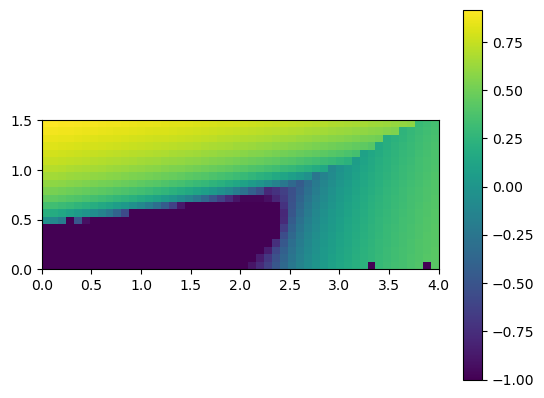

In [15]:
plt.imshow(np.log10(gap).T, origin='lower', extent=(Us.min(), Us.max(), Vs.min(), Vs.max()), vmin=-1)
plt.colorbar()

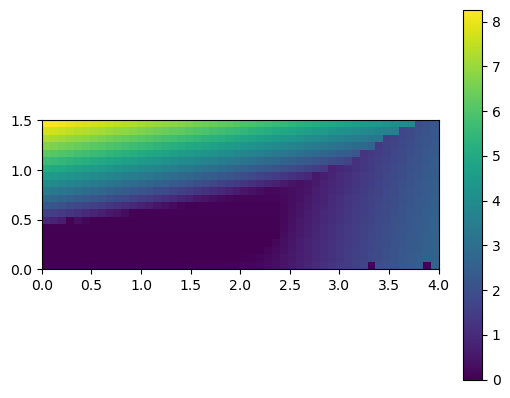

In [16]:
plt.imshow((gap).T, origin='lower', extent=(Us.min(), Us.max(), Vs.min(), Vs.max()), vmin=0)
plt.colorbar()

In [17]:
import xarray as xr
gap_da = xr.DataArray(data=gap, coords=dict(Us=Us, Vs=Vs))

In [18]:
gap_da.to_netcdf('./data/graphene_example.nc')